In [1]:
from typing import List, Optional, Generator
from datetime import datetime, timezone, timedelta
import random
import uuid
import hashlib
import os
import math
import pickle

import numpy as np
import pandas as pd
import dask
import xgboost
import dask_xgboost
from dask.distributed import Client, progress
from pathlib import Path
import dask.dataframe as dd
from dask import delayed
from dask_ml.model_selection import train_test_split



In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33193 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.54 GB


In [3]:
df = dd.read_parquet(f'./data/labeled/sampled/', engine='fastparquet')
df_validation = dd.read_parquet(f'./data/labeled/validation/', engine='fastparquet')

/opt/dev/anaconda3/envs/dask/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/opt/dev/anaconda3/envs/dask/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)
/opt/dev/anaconda3/envs/dask/lib/python3.7/site-packages/fas

In [4]:
def features_and_labels(df):
    X = df[['order_amount', 'emails_by_customer_id', 'ip_addrs_by_customer_id', 'order_amount_mean_by_customer_id',
           'order_amount_std_by_customer_id', 'order_amount_min_by_customer_id', 'order_amount_max_by_customer_id',
           'order_amount_sum_by_customer_id', 'customer_ids_by_email', 'order_amount_mean_by_email',
           'order_amount_std_by_email', 'order_amount_min_by_email', 'order_amount_max_by_email',
           'order_amount_sum_by_email']]
    y = df[['is_fraud']]
    return X, y

X, y = features_and_labels(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)


/opt/dev/anaconda3/envs/dask/lib/python3.7/site-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


In [5]:
#XGBoost
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01,
          'min_child_weight': 0.5, 'verbosity': 1, 'tree_method': 'hist'}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=4)

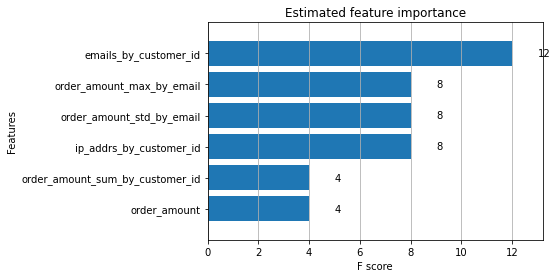

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [7]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()

In [8]:
# #SVC
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
#               "kernel": ['rbf', 'poly', 'sigmoid'],
#               "shrinking": [True, False]}

# grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
#                            param_grid=param_grid,
#                            return_train_score=False,
#                            iid=True,
#                            cv=3,
#                            n_jobs=-1)

# import joblib

# #with joblib.parallel_backend('dask'):
# #    grid_search.fit(X_train, y_train)
# grid_search.fit(X_train, y_train)
# y_hat = grid_search.predict(X_test)

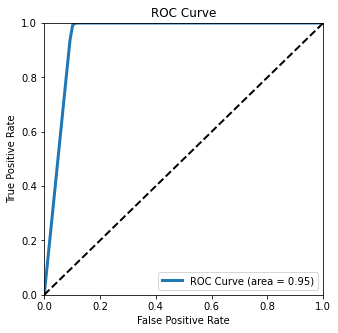

In [9]:
from sklearn.metrics import roc_curve

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [10]:
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score
f1 = f1_score(y_test, np.around(y_hat))
precision = precision_score(y_test, np.around(y_hat))
recall = recall_score(y_test, np.around(y_hat))

average_precision = average_precision_score(y_test, y_hat)

print('TEST: Average precision-recall score:{0:0.2f} precision:{1: 0.2f} recall:{1: 0.2f} f1:{1: 0.2f}'.format(
      average_precision, precision, recall, f1))

TEST: Average precision-recall score:0.83 precision: 0.83 recall: 0.83 f1: 0.83


In [11]:
# Validation with larger and recent data
X_valid, y_valid = features_and_labels(df_validation)
y_pred = dask_xgboost.predict(client, bst, X_valid).persist()
y_valid, y_pred = dask.compute(y_valid, y_pred)

In [12]:
f1 = f1_score(y_valid, np.around(y_pred))
precision = precision_score(y_valid, np.around(y_pred))
recall = recall_score(y_valid, np.around(y_pred))

average_precision = average_precision_score(y_valid, y_pred)

print('VALIDATION: Average precision-recall score:{0:0.2f} precision:{1: 0.2f} recall:{1: 0.2f} f1:{1: 0.2f}'.format(
      average_precision, precision, recall, f1))

VALIDATION: Average precision-recall score:0.50 precision: 0.49 recall: 0.49 f1: 0.49


In [13]:
os.makedirs('./data/model/xgb/', exist_ok=True)
with open('./data/model/xgb/bst.pkl', 'wb') as fb:
    pickle.dump(bst, fb)